In [1]:
#pip install geopandas rioxarray shapely rioxarray xarray-spatial geocube rasterstats pystac pystac_client planetary_computer rich

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.8/239.8 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 44.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 90.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 27.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 36.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB

In [1]:
import os 
import numpy as np
import pandas as pd
import rasterio
import os
import pystac
import pystac_client
import planetary_computer
import geopandas as gpd
from rich.table import Table
import rioxarray
import requests
from shapely.geometry import Polygon, shape, box
from shapely.ops import transform
from rich.table import Table
from rioxarray.merge import merge_arrays
from rasterio.plot import plotting_extent
from rasterstats import zonal_stats
from xrspatial.zonal import stats as zonal_stats
from geocube.api.core import make_geocube
import xarray
from azureml.core import Workspace, Dataset
import multiprocessing
from multiprocessing import Pool
from functools import partial
from rasterio.plot import show

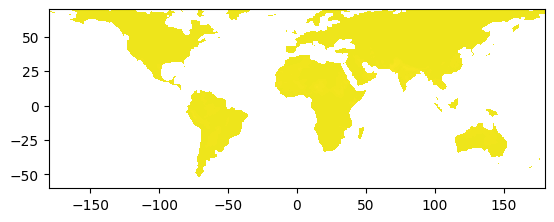

<Axes: >

In [5]:
directory = os.getcwd() + '/data'                                                                               # set directory
heat_data = rasterio.open('global_mean_wbgt_30.tif', masked=True)                                               # load heat data       
show(heat_data)

In [6]:
# Define the function to process a single file
def process_file(directory, fileName):
    if fileName.endswith(".tif"):
        f = os.path.join(directory, fileName)
        countryCode = fileName[0:3]
        outFileName = directory + '/' + countryCode + '_heat_flood_extract.csv'

        if os.path.exists(outFileName):
            print(countryCode + ' - file exists - skipping')
            return

        print(f"{countryCode} - Started")

        country_pop = rioxarray.open_rasterio(f, masked=True)                                                   # open individual pop file with filepath

        country_box = country_pop.rio.bounds()                                                                  # find bounding box for country

        country_pop.name = "pop_data"                                                                           # change column header to pop_data

        country_pop_df = country_pop.squeeze().to_dataframe().reset_index()                                     # squeeze to data frame

        geometry = gpd.points_from_xy(country_pop_df.x, country_pop_df.y)                                       # set geometry

        country_pop_gdf = gpd.GeoDataFrame(country_pop_df, crs=country_pop.rio.crs, geometry=geometry)          # convert to geopandas df

        country_pop_gdf.dropna(subset=['pop_data'], how='all', inplace=True)                                    # remove pixels with NA people

        country_pop_gdf.index = range(len(country_pop_gdf))
        coords = [(x,y) for x, y in zip(country_pop_gdf.x, country_pop_gdf.y)]
        country_pop_gdf['heat_value'] = [x[0] for x in heat_data.sample(coords)]                                # extract heat data

        print(f"{countryCode} - Heat Completed") # STATUS CHECK
                
        catalog = pystac_client.Client.open(
                "https://planetarycomputer.microsoft.com/api/stac/v1", 
                modifier=planetary_computer.sign_inplace,)                                                      # access flood data on PC

        AOI = shape({ "coordinates": [[
                [country_box[0],
                 country_box[1]],
                    
                  [country_box[0],
                  country_box[3]],
                    
                  [country_box[2],
                  country_box[1]],
                    
                [country_box[2],
                 country_box[3]]
                   ]],
                  "type": "Polygon"}).envelope                                                                   # use bounding box from before to get data for each country


        jrc = catalog.search(collections=["jrc-gsw"], intersects=AOI)
        items = jrc.item_collection()                                                                            # Use STACAPI to access the collection (find the number of images for each bounding box)

        n = len(items)
        doubles = dict()
                
        for i in range(0, n):
                item = items[i]
                    
                doubles[i] = rioxarray.open_rasterio(item.assets["occurrence"].href, overview_level=4).squeeze() # use this loop to load each image

        flood_data = merge_arrays(dataarrays = list(doubles.values()), crs = "EPSG:4326")                        # merge each image that's been loaded

        flood_data = flood_data.where(flood_data <= 80, np.nan)
                
        flood_data.rio.write_nodata(flood_data.rio.nodata, encoded=True, inplace=True)                           # update nodata value to show the data has been masked

        country_pop_gdf_buff = country_pop_gdf.copy()
        country_pop_gdf_buff["geometry"] = country_pop_gdf.geometry.buffer(0.008)                                # create buffered polygon for each population point
        country_pop_gdf_buff["id"] = country_pop_gdf_buff.index + 1                                              # used to extract flood mean (also add index value here to merge back)


        out_grid = make_geocube(
            vector_data= country_pop_gdf_buff,
            measurements=["id"],
            like=flood_data, # ensure the data are on the same grid
            )

            # merge the two together
        out_grid["flood_data"] = (flood_data.dims, flood_data.values, flood_data.attrs, flood_data.encoding)

        grouped_flood_data = out_grid.drop("spatial_ref").groupby(out_grid.id)

        grid_mean = grouped_flood_data.mean(skipna=True).rename({"flood_data": "flood_value"})

        zonal_stats = xarray.merge([grid_mean]).to_dataframe()

        # merge back in w geopandas df from before
        country_final_data = country_pop_gdf_buff.merge(zonal_stats, on='id')
        country_final_data = pd.DataFrame(country_final_data.drop(columns=['geometry', 'band', 'spatial_ref']))

        print(f"{countryCode} - Flood Completed") # STATUS CHECK

        countryCode = countryCode[0:3]

        country_final_data["country_iso"] = countryCode                                                         # add country code as a final column for reference
                
        country_final_data.to_csv(outFileName, index = False)

        print(f"{countryCode} - Completed & Saved")

if __name__ == "__main__":
    directory = directory
    files = os.listdir(directory)

    # Create a pool of workers to process files in parallel
    with Pool(processes=8) as pool:  # You can adjust the number of processes as needed
        # Use partial to create a function with a fixed directory argument
        process_func = partial(process_file, directory)

        # Map the function to the list of files for parallel execution
        pool.map(process_func, files)


bdi - Starteddnk - Startedcub - Startedcmr - Startedbrb - Started




abw - Started
are - Startedbhs - Started

abw - Heat Completed
brb - Heat Completed
bdi - Heat Completed
brb - Flood Completed
brb - Completed & Saved
brn - Started
abw - Flood Completed
abw - Completed & Saved
afg - Started
brn - Heat Completed
bhs - Heat Completed
dnk - Heat Completed
are - Heat Completed
cub - Heat Completed
brn - Flood Completed
brn - Completed & Saved
btn - Started
btn - Heat Completed
cmr - Heat Completed
bhs - Flood Completed
bhs - Completed & Saved
bih - Started
bih - Heat Completed
bdi - Flood Completed
bdi - Completed & Saved
bel - Started
bel - Heat Completed
afg - Heat Completed
btn - Flood Completed
btn - Completed & Saved
bwa - Started
bel - Flood Completed
bel - Completed & Saved
ben - Started
bwa - Heat Completed
dnk - Flood Completed
dnk - Completed & Saved
dom - Started
ben - Heat Completed
dom - Heat Completed
are - Flood Completed
are - Completed & Saved
arg - Started
bih - Flood 

/tmp/ipykernel_5431/2525697763.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_pop_gdf_buff["geometry"] = country_pop_gdf.geometry.buffer(0.008)                               # create buffered polygon for each population point
/tmp/ipykernel_5431/2525697763.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_pop_gdf_buff["geometry"] = country_pop_gdf.geometry.buffer(0.008)                               # create buffered polygon for each population point
/tmp/ipykernel_5431/2525697763.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_pop_gdf_buf